<a href="https://colab.research.google.com/github/MariachiAncona/APIT_TEST/blob/main/Proyecto_APIT_TF_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Proyecto: Modelo de lenguaje para reconocer si una opinión es buena en twitter sobre un tema específico**

*   Aquino Santiago Rogelio Gerardo
*   Moreno Madrid Maria Guadalupe
*   Ramírez Ancona Simón Eduardo
*   Ruiz Pérez Ariel

### **Objetivo:**
A partir del corpus **corpusML.txt** realizar un modelo del lenguaje neuronal con base en la arquitectura propuesta por Bengio (2003).

### **Introducion:**


Los modelos del lenguajes son una herramienta esencial en el PLN. Éstos se utilizan en múltiples aplicaciones. Su objetivo es estimar probabilidades de cadenas:

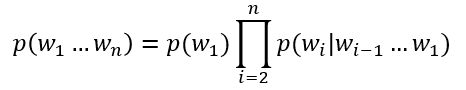

Aproximan estas probabilidades por medio de asumir la propiedad de Markov (n-gramas):

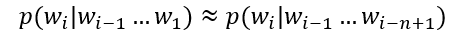

Un modelo (estadístico) del lenguaje es µ = (Σ, P), tal que Σ es vocabulario y P medida de probabilidad sobre $Σ^*$

Se busca estimar un modelo µ = (Σ, A, Π)tal que Σ es el vocabulario, A son probabilidades de transición:

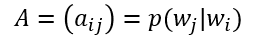

Y Π son probabilidades iniciales:

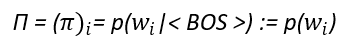

De esta forma, se pueden obtener las probabilidades de cadenas como:

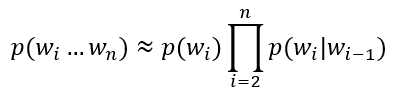

Bengio (2003) propone estimar los modelos del lenguaje a partir de las redes neuronales.
Sus objetivos son:

1.   Asociar cada palabra en el vocabulario con un vector distribuido en $R^b$
2.   Expresar la función de distribución conjunta de las secuencias de palabras por medio de estos vectores.
3.   Aprender de manera simultánea los vectores distribuidos y los parámetros de la función de probabilidad.






### **Desarrollo:**

El corpus será una colección de tweets, cada uno de los que se obtengan con la herramienta twint será utilizado como una sentencia, que será almacenada como un elemento de la lista para entrenar y evaluar el modelo.


---
Instalando twint para obtener los datos que se usarán como entrada del modelo de clasificación.

__Nota: se debe ejecutar esta celda y después reiniciar el runtime (solo reiniciar) porque algunas bibliotecas requieren el reinicio para poder ejecutarse, después volver a ejecutar todas las celdas__.

In [1]:
!pip install -qq whatthelang
!pip install nest_asyncio
!pip install git+https://github.com/twintproject/twint.git@origin/master#egg=twint

Como el modelo se entrena a partir de reseñas de peliculas en inglés los tweets deberán ser extraídos en inglés.

In [57]:
import nest_asyncio
nest_asyncio.apply()
from whatthelang import WhatTheLang


import twint

def detect_lang(text):
  wtl = WhatTheLang()
  try: 
    return wtl.predict_lang(text)
  except Exception:
    return 'exp'

# Function for instantiate and configure the twint-object
def create_twint_object(target, date="2021-01-21", limit=100):
  c = twint.Config()
  c.Store_object = True
  c.Pandas =True
  c.Search = target
  c.Since = date
  c.Limit = limit
  c.Lang = 'en'
  twint.run.Search(c)
  # Quick check
  #twint.storage.panda.Tweets_df.head()
  # Cleanup duplicates.
  tweets = twint.storage.panda.Tweets_df.drop_duplicates(subset=['id'])

  # Reindex
  tweets.index = range(len(tweets))
  #Return english tweets
  tweets['lang'] = tweets['tweet'].map(lambda t: detect_lang(t))
  tweets = tweets[tweets.lang == 'en']

  corpus = []

  for row in tweets.index:
    corpus.append(tweets['tweet'][row])
    #print(tweets['tweet'][row])

  return corpus

Creando el corpus de prueba desde twitter.

In [6]:
corpus_capitol = create_twint_object("#Capitol", "2021-01-21", 100)

1352441550333087744 2021-01-22 02:22:47 +0000 <jamiecbarnett> Anyone else uncomfortable with @GOP nutjobs bringing guns into the #Capitol? I wouldn't trust someone like @laurenboebert or @mtgreenee with a gun around a lawmaker I care about. C'mon, #Congress!
1352439775005958147 2021-01-22 02:15:44 +0000 <clio_uncensored> Ohhh shiiit! #rap #hiphop #capitol
1352439558756036608 2021-01-22 02:14:52 +0000 <Pandadollbaby> @TheView @MeghanMcCain #RepublicanTerrorists attacked OUR #Capitol   Tag who the #terrorist #Republicans are if they don't want to all be labeled #terrorists   .@FriendEden100  .@WiccanMethusela  .@JtOptimist  .@forevercats  .@JIMBO_Biden2020  .@sunny  .@JoyVBehar
1352439373137145857 2021-01-22 02:14:08 +0000 <RuanoFaxas> @Newsweek "#WhiteHouse Cleanup After Donald #Trump's Departure Cost at Least $127,000. With 132 rooms, 35 bathrooms, 412 doors and 28 fireplaces the #WH is not an easy building to deep-clean" #Coronavirus #Covid #Melania #Pence #GOP #MAGA #Terrorism #Capit

Para tener una idea de que tan bueno es el modelo que estimamos, podemos utilizar la entropía cruzada empírica dada por la función:

$$H_E(p) = -\frac{1}{M} \sum_{x_1,...,x_m}^N \log p(x_1, ...x_m)$$
En este caso, el modelo con menor entropía será aquel que mejor prediga una (o varias) cadenas no vistas. Por tanto, consideraremos que generaliza mejor.
La perplejidad se define en base a esta entropía como $2^{H_E(p)}$.

Se importan todas las biliotecas necesarias para poder crear un modelo secuencial de clasificación con keras.

In [7]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow  
%matplotlib inline
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

Se usará un dataset con etiquetas proporcionado por google basado en resañas de películas y etiquetado con 0 si la reseña fue negativa y con 1 si la reseña fue positiva.

In [8]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 5s 0us/step


Revisando el contenido del archivo descargado en la ruta establecida en dataset_dir y previamente descomprimido.

In [9]:
os.listdir(dataset_dir)

['README', 'test', 'imdb.vocab', 'imdbEr.txt', 'train']

La carpeta _train_ contiene dos carpetas más, una para las reseñas positivas y otra para las reseñas negativas.

In [10]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['pos',
 'urls_neg.txt',
 'urls_unsup.txt',
 'urls_pos.txt',
 'neg',
 'unsup',
 'labeledBow.feat',
 'unsupBow.feat']

Ejemplo de una reseña positiva

In [11]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


Se remueven los folders innecesarios.

In [12]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Se dividirán los documentos en tres conjuntos, el primero para entrenamiento, el segundo para validación y el tercero para test.

También se agrega una semilla para el generador de números aleatorios y así evitar que se utilce la misma reseña para ambos conjuntos, otra opción sería agregar el parámetro shuffle como _False_ para evitar el mismo problema, sin embargo en este caso la generación de los conjuntos será secuencial.

Se define el tamaño de entradas para el entrenamiento en 32 para cada iteración.

El método text_dataset_from_directory nos permite utilizar las carpetas de forma directa para poder tener los conjuntos agrupados con su etiqueta.

In [13]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Ejemplo de reseña y etiqueta.

In [14]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(5):
    print("Reseña", text_batch.numpy()[i])
    print("Etiqueta", label_batch.numpy()[i])

Reseña b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Etiqueta 0
Reseña b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get in

Las clases son 0 para las reseñas negativas y 1 para las reseñas positivas.

In [15]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Se genera el conjunto de validación con los 5000 archivos restantes.

In [16]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Finalmente se genera el conjunto de evalución que serán todos los archivos de la carpeta de evaluación.

In [18]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


Se agrega una función para el preprocesamiento de los datos, esta realizará la conversión a minúsculas, removerá las etiquetas del _html_ y finalmente hará la tokenización usando expresiones regulares.

In [19]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

El texto se deberá vectorizar, esto se realiza utilizando la herramienta de _TextVectorization_ de keras.

Dentro de los argumentos en standarize se pasa como parámetro la función creada anteriormente para que al vectorizar los conjuntos que se han creado tengan el mismo preprocesamiento.

In [20]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Lo siguiente será realizar un diciconario indexado 

In [21]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Se define una función para la vectorización del texto, esta función devuelve una capa de vecorización.

In [22]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

Se prueba el funcuionamiento para 32 reseñas con sus etiquetas.

In [23]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

Ejemplo de la capa de vectorización que se usará para el modelo.

In [25]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1500])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  seemingly
 313 --->  night
Vocabulary size: 10000


Se aplica la capa de _TextVectorization_ para los 3 conjuntos.

In [26]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Se optimizará el modelo agregando las opciones _.cache_ para que los datos se mantengan en memoria y la opción _.prefetch_ que permite que mientras se ejecuten las operaciones de un dato se este leyendo el dato siguiente.

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Se procede a crear el modelo, este será un modelo secuencial, con las capas de _embedding_, que toma las entradas de texto ya convertidas a enteros, una capa de pooling para trabajar con vectores de tamaño constante, las capas de _dropout_ automáticamente se consideran para el entrenamiento nadamás, a menos que se especifíque explicitamente lo contrario, estas capas ayudan a prevenir el overfitting del modelo, finalmente la capa Dense del modelo es agregada al final para obtener una salida.

In [28]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


Descripción del modelo:

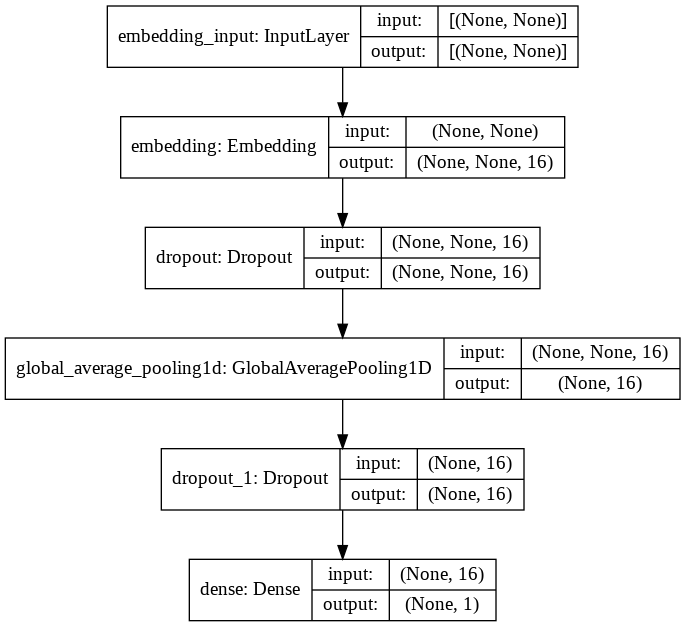

In [30]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

Se compila el modelo, se agrega un optimizador ADAM (Para optimización del learning rate), con las métricas para clasificación binaria y como función de pérdida se usará la entropía cruzada binaria de keras.

In [31]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

Se fija el número de épocas para el entrenamiento y el método _.fit_ retorna el histórico de los valores que se usarán para gráficar.

In [32]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/15
625/625 [==============================] - 13s 19ms/step - loss: 0.6824 - binary_accuracy: 0.6103 - val_loss: 0.6144 - val_binary_accuracy: 0.7726
Epoch 2/15
625/625 [==============================] - 4s 7ms/step - loss: 0.5799 - binary_accuracy: 0.7831 - val_loss: 0.4976 - val_binary_accuracy: 0.8220
Epoch 3/15
625/625 [==============================] - 4s 7ms/step - loss: 0.4651 - binary_accuracy: 0.8343 - val_loss: 0.4195 - val_binary_accuracy: 0.8484
Epoch 4/15
625/625 [==============================] - 4s 6ms/step - loss: 0.3900 - binary_accuracy: 0.8602 - val_loss: 0.3731 - val_binary_accuracy: 0.8610
Epoch 5/15
625/625 [==============================] - 4s 6ms/step - loss: 0.3446 - binary_accuracy: 0.8765 - val_loss: 0.3447 - val_binary_accuracy: 0.8680
Epoch 6/15
625/625 [==============================] - 4s 6ms/step - loss: 0.3112 - binary_accuracy: 0.8877 - val_loss: 0.3259 - val_binary_accuracy: 0.8716
Epoch 7/15
625/625 [==============================] - 4s 6ms/s

Al realizar la evaluación retorna las métricas de la función de pérdida y de precisión.

782/782 [==============================] - 10s 12ms/step - loss: 0.3112 - binary_accuracy: 0.8736


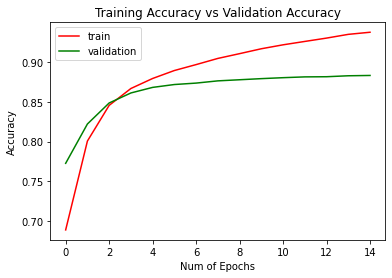

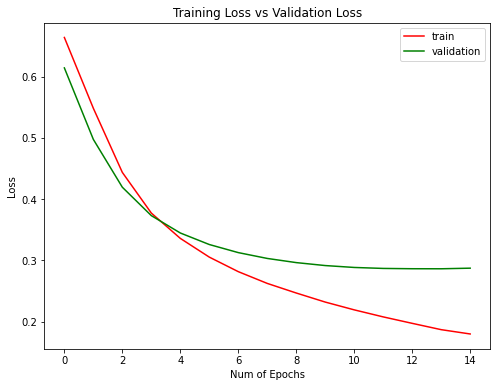

In [33]:
loss, accuracy = model.evaluate(test_ds)

#Muchas líneas para que las gráficas se vean más decentes.
plt.figure(0)  
plt.plot(history.history['binary_accuracy'],'r')  
plt.plot(history.history['val_binary_accuracy'],'g')  
plt.xticks(np.arange(0, epochs + 1, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, epochs + 1, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()

Se crea el modelo completo con las capas de vectorización a la entrada y una función de activación a la salida.

In [34]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 11s 14ms/step - loss: 0.3157 - accuracy: 0.8713
0.8736400008201599


El resultado anterior nos muestra una precisión de 87% aproximadamente, lo siguiente será probar directamente con el dataset creado a partir de los twits recolectados, entre más próximo sea el número a 1 el comentario sera más positvo y conforme se aproxime a cero el comentario será negativo.

In [72]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was bad..."
]

export_model.predict(examples)
#test_example = export_model.predict(examples)
#label_example = np.argmax(test_example, axis=-1)
#print("{}\n{}".format(test_example, label_example))

[[0.64675325]
 [0.4295048 ]
 [0.36078286]]
[0 0 0]


In [36]:
#ejemplos con corpus
tweets_predicted = export_model.predict(corpus_capitol)
class_predicted = np.argmax(tweets_predicted, axis=-1)

Finalmente se crea una pequeña función para presentar la etiqueta de cada tweet. 

In [87]:
def print_predicted(predicted, corpus):
  for t in range(len(predicted)):
    print("Sample number {} of {} (Twitter Set)\n".format(t, len(corpus)-1))
    if t == 0 :print("{:10}".format("Etiqueta"))
    print("{:3}:\t{}\n".format(predicted[t], corpus[t]))

Función para definir que sucedió con las opiniones encontradas.

In [78]:
def resume_opinions(predicted_values):
  count_ones, count_zeros = 0, 0
  labels = []
  for tweet in predicted_values:
    #print(tweet)
    if tweet > 0.4999:
      labels.append(1)
      count_ones += 1 
    else:
      labels.append(0)
      count_zeros += 1

  if count_ones > count_zeros:
    print("Hay más reseñas positvas obre el capitoilio que negativas")
  elif count_ones == count_zeros:
    print("Las opiniones son iguales")
  else:
    print("Las opiniones son malas")
  return labels


In [80]:
labels_capitol = resume_opinions(tweets_predicted)
print_predicted(labels_capitol, corpus_capitol)
#print(tweets_predicted)

Hay más reseñas positvas obre el capitoilio que negativas
Sample number 0 of 187 (Twitter Set)

Etiqueta  
  0:	Anyone else uncomfortable with @GOP nutjobs bringing guns into the #Capitol? I wouldn't trust someone like @laurenboebert or @mtgreenee with a gun around a lawmaker I care about. C'mon, #Congress!

Sample number 1 of 187 (Twitter Set)

  0:	@TheView @MeghanMcCain #RepublicanTerrorists attacked OUR #Capitol   Tag who the #terrorist #Republicans are if they don't want to all be labeled #terrorists   .@FriendEden100  .@WiccanMethusela  .@JtOptimist  .@forevercats  .@JIMBO_Biden2020  .@sunny  .@JoyVBehar

Sample number 2 of 187 (Twitter Set)

  1:	@Newsweek "#WhiteHouse Cleanup After Donald #Trump's Departure Cost at Least $127,000. With 132 rooms, 35 bathrooms, 412 doors and 28 fireplaces the #WH is not an easy building to deep-clean" #Coronavirus #Covid #Melania #Pence #GOP #MAGA #Terrorism #Capitol #Election #USA #Biden #Jill  https://t.co/Syr9nnwo1I

Sample number 3 of 187 (T

Otro ejemplo:

In [67]:
corpus_congrats = create_twint_object("excellent", "2021-01-20", 100)

1352448335681093633 2021-01-22 02:49:45 +0000 <DrReins> @therecount They always have expectations so High for anyone but the dotard. He shouldn’t be the barometer of where we aim however it is unreasonable set such high expectations. 100 million is exponentially more than we were headed before and an excellent start.
1352448335651639296 2021-01-22 02:49:45 +0000 <chocodaddy__> ok ni son las 9 y solo me falta una tarea excellent progress😫
1352448335286857728 2021-01-22 02:49:45 +0000 <TruthSurrogate> The Biden Administration is off an excellent start destroying over 50,000 jobs in less than 48 hours. Who is having buyers remorse, be honest?   #NotMyPresident #ImpeachBidenNow #BidenHarrisInauguration #BidenCrimeFamily #HunterBiden #GreatReset #NewWorldOrder #NewAccount #Trump
1352448328072486913 2021-01-22 02:49:43 +0000 <dlaw51> @SDuncovered Excellent!
1352448322116734976 2021-01-22 02:49:41 +0000 <alteducator216> This is excellent!
1352448321818914819 2021-01-22 02:49:41 +0000 <KVP798>

In [82]:
tweets_congrats = export_model.predict(corpus_congrats)
labels_congrats = resume_opinions(tweets_congrats)
print_predicted(labels_congrats, corpus_congrats)

Hay más reseñas positvas obre el capitoilio que negativas
Sample number 0 of 92 (Twitter Set)

Etiqueta  
  1:	@therecount They always have expectations so High for anyone but the dotard. He shouldn’t be the barometer of where we aim however it is unreasonable set such high expectations. 100 million is exponentially more than we were headed before and an excellent start.

Sample number 1 of 92 (Twitter Set)

  1:	The Biden Administration is off an excellent start destroying over 50,000 jobs in less than 48 hours. Who is having buyers remorse, be honest?   #NotMyPresident #ImpeachBidenNow #BidenHarrisInauguration #BidenCrimeFamily #HunterBiden #GreatReset #NewWorldOrder #NewAccount #Trump

Sample number 2 of 92 (Twitter Set)

  1:	@SDuncovered Excellent!

Sample number 3 of 92 (Twitter Set)

  1:	This is excellent!

Sample number 4 of 92 (Twitter Set)

  1:	@ReesusP @SenTedCruz My union needs to consider that as our work slows and it's slowing enough that people are retiring at 10 years

Último ejemplo:

In [85]:
corpus_hate = create_twint_object("hate", "2021-01-20", 100)

1352455012148944902 2021-01-22 03:16:16 +0000 <kkaecals> fuck i hate restricting but i also love it sm
1352455011738013697 2021-01-22 03:16:16 +0000 <Eve_172020> @bigshitxtalker Now why I thought the name was sent from heaven all this time?😭😭
1352455011364724737 2021-01-22 03:16:16 +0000 <Dessy_Hudson> I am over this pregnancy 😩 I love it but I don’t like the throwing up part 24/7 I hate having HG . I already lost 5-7 pounds 😒
1352455011213529088 2021-01-22 03:16:16 +0000 <tanuki_adalynn> @CEOofRukaGang I hate that it actually makes sense lmfao
1352455009817030658 2021-01-22 03:16:16 +0000 <StateNYKPOD> Elfrid Payton man fucking hate this guy man lmfao
1352455009804275712 2021-01-22 03:16:16 +0000 <minna_bookeeYa> @xx_hate_ 웅,,ㅠ
1352455009678536707 2021-01-22 03:16:16 +0000 <DeepC91169> @DrjimPhifer I do, but I think that the controls on hate speech will be written into law expeditiously. If any Republicans try to block it they will never hold their seats again. We are now a force that

In [88]:
tweets_hate = export_model.predict(corpus_hate)
labels_hate = resume_opinions(tweets_hate)
print_predicted(labels_hate, corpus_hate)

Hay más reseñas positvas obre el capitoilio que negativas
Sample number 0 of 82 (Twitter Set)

Etiqueta  
  1:	fuck i hate restricting but i also love it sm

Sample number 1 of 82 (Twitter Set)

  1:	@bigshitxtalker Now why I thought the name was sent from heaven all this time?😭😭

Sample number 2 of 82 (Twitter Set)

  0:	I am over this pregnancy 😩 I love it but I don’t like the throwing up part 24/7 I hate having HG . I already lost 5-7 pounds 😒

Sample number 3 of 82 (Twitter Set)

  1:	@CEOofRukaGang I hate that it actually makes sense lmfao

Sample number 4 of 82 (Twitter Set)

  1:	Elfrid Payton man fucking hate this guy man lmfao

Sample number 5 of 82 (Twitter Set)

  1:	@DrjimPhifer I do, but I think that the controls on hate speech will be written into law expeditiously. If any Republicans try to block it they will never hold their seats again. We are now a force that will not be denied.

Sample number 6 of 82 (Twitter Set)

  1:	Time to let the attention go to my head

Sample

__Conclusiones:__

Los textos classificados o etiquetados son poco comunes, así que en este caso solo se utilizó el dataset clasificado en 2 clases para entrenar el modelo y poder clasificar tweets.

Al crear un modelo que su primera capa limpia el texto y lo vectoriza permite un uso muy flexible del desarrollo, también es muy sencillo modificar los hiperparámetros, lo que hace que usar el modelo sea tan sencillo como pasarle una lista como argumento al método _.predic_ del modelo.


###**Referencias:**

*   https://colab.research.google.com/drive/17p3ef9HyZ9N9rixGdr5yhLd_VGT0zpNk?usp=sharing
*   https://github.com/VMijangos/Curso-Procesamiento-de-Lenguaje-Natural/blob/master/Notebooks/09b%20Language_model_bigram_big.ipynb
*   https://github.com/penserbjorne/clase-pln-2020-2/blob/master/02_practica/practica_2.ipynb
*   Yoshua Bengio, Réjean Ducharme, Pascal Vincent, and Christian Jauvin.
A neural probabilistic language model.
Journal of machine learning research, 3(Feb):1137–1155, 2003.

